<a href="https://colab.research.google.com/github/dennismugane/projo/blob/master/ANALYSIS_TO_FIND_NUMBER_OF_SURVIVORS_ON_THE_TITANIC_DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="green">*To start working on this notebook, or any other notebook that we will use in the Moringa Data Science Course, we will need to save our own copy of it. We can do this by clicking File > Save a Copy in Drive. We will then be able to make edits to our own copy of this notebook.*</font>

# Python Programming: K-Nearest Neighbours (KNN): Exploratory Data Analysis

## 1. Defining the Question




### a) Specifying the Data Analytic Question

We want to look the number of people who survived on the titanic  crush, and to know which features contributed to the chances of survivor

### b) Defining the Metric for Success

To understand the number of survivors,

we will use several models to understand which features are most impactful in influencing the prediction of the model created. The aim of the model is to achieve an Accuracy  above 85% and F1 score above 85%.

### c) Understanding the context 

The titanic dataset has 12 columns:

 Survived - Survival (0 = No; 1 = Yes)

 Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)

  Name - Name

 Sex - Sex

 Age - Age

 SibSp - Number of Siblings/Spouses Aboard

 Parch - Number of Parents/Children Aboard

 Ticket - Ticket Number

 Fare - Passenger Fare (British pound)

 Cabin - Cabin

 Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)


## 2. Reading the Data

In [304]:
#importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.pylabtools import figsize

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction import DictVectorizer

import xgboost as xgb

from sklearn.model_selection import cross_val_score

from sklearn_pandas import DataFrameMapper, CategoricalImputer

from sklearn.pipeline import FeatureUnion

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.ensemble import AdaBoostClassifier

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVC

from sklearn import metrics

from sklearn.metrics import accuracy_score

from sklearn.tree import export_graphviz

from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier

from six import StringIO  

from IPython.display import Image  

import pydotplus

from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report



## 2. Checking the Data

In [305]:
#loading the dataset from the source
data = pd.read_csv('/content/train (5).csv')

In [306]:
# Determining the no. of records in our dataset
data.shape

(891, 12)

In [307]:
#previewing the head of the data
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [308]:
# Previewing the bottom of our dataset
data.tail() 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [309]:
# Checking whether each column has an appropriate datatype
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## 3. Understanding the data abit more

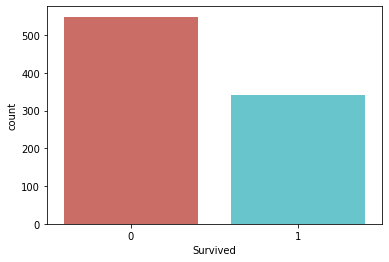

In [310]:
# Checking that our target variable is binary
# Since we are building a model to predict survival of passangers from the Titanic, 
# our target is going to be "Survived" variable from the titanic dataframe. 
# To make sure that it's a binary variable, let's use Seaborn's countplot() function.
# 
sns.countplot(x='Survived',data=data, palette='hls')

# from the output we see that the Survived variable is binary (0 - did not survive / 1 - survived)

In [311]:
#checking for missing values
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [312]:
# Checking for data info
# Ok, so there are only 891 rows in the titanic data frame. 
# Cabin is almost all missing values, so we can drop that variable completely, 
# but what about age? Age seems like a relevant predictor for survival right? 
# We'd want to keep the variables, but it has 177 missing values.
# We are going to need to find a way to approximate for those missing values!
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [313]:
# Dealing with the Missing Data
# Taking care of missing values
# So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:
# ---
# Survived - This variable is obviously relevant.
# Pclass - Does a passenger's class on the boat affect their survivability?
# Sex - Could a passenger's gender impact their survival rate?
# Age - Does a person's age impact their survival rate?
# SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability
# Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability
# Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.
# Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.
# What about a person's name, ticket number, and passenger ID number? They're irrelavant for predicting survivability. 
# And as we recall, the cabin variable is almost all missing values, so we can just drop all of these.
#
titanic_data = data.drop(['PassengerId','Name','Ticket','Cabin'], axis = 1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


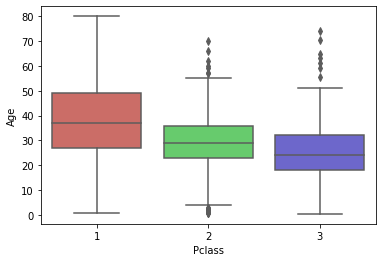

In [314]:
# More data cleaning procedures
# Imputing missing values
# ---
# Let's look at how passenger age is related to their class as a passenger on the boat.
# 
sns.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls')

In [315]:
titanic_data.head()

# Speaking roughly, we could say that the younger a passenger is, the more likely it is for them to be in 3rd class. 
# The older a passenger is, the more likely it is for them to be in 1st class. 
# So there is a loose relationship between these variables. 
# So, let's write a function that approximates a passengers age, based on their class. 
# From the box plot, it looks like the average age of 1st class passengers 
# is about 37, 2nd class passengers is 29, and 3rd class pasengers is 24.

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [316]:
# So let's write a function that finds each null value in the Age variable, and for each null, 
# checks the value of the Pclass and assigns an age value according to the average age of passengers in that class.

def age_approx(cols):
  age = cols[0]
  pclass = cols[1]

  if pd.isnull(age):
    if pclass == 1:
      return 37
    elif pclass == 2:
      return 29
    else:
      return 24
  else:
     return age


In [317]:
# When we apply the function and check again for null values, we see that there are no more null values in the age variable.
#
titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [318]:
titanic_data['Age'].describe()

count    891.000000
mean      29.066409
std       13.244532
min        0.420000
25%       22.000000
50%       26.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

In [319]:
# There are 2 null values in the embarked variable. We can drop those 2 records 
# without loosing too much important information from our dataset, so we will do that.
#
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [320]:
# Converting categorical variables to a dummy indicators
# ---
# The next thing we need to do is reformat our variables so that they work with the model. 
# Specifically, we need to reformat the Sex and Embarked variables into numeric variables.
#
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [321]:
embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)
embark_location.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [322]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [323]:
titanic_data.drop(['Sex','Embarked'], axis =1,inplace = True)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [324]:
titanic_new = pd.concat([titanic_data,gender,embark_location],axis=1)
titanic_new.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


## 6. Exploratory Analysis

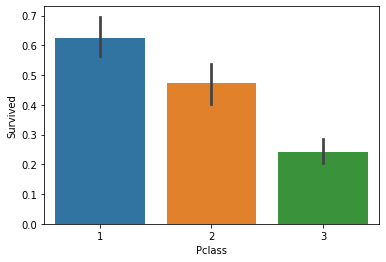

In [325]:
# Ploting the barplot summaries and recording our observations
#we can make an observation that the status of the class determined the number of survivors
sns.barplot(x = 'Pclass', y='Survived',data=titanic_new)

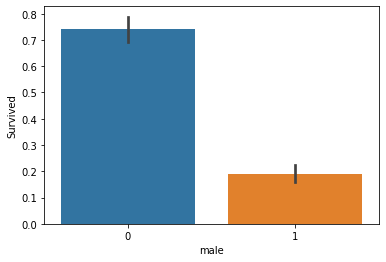

In [326]:
sns.barplot(x ='male',y='Survived',data=titanic_new)
#male had more survivor chances than females.

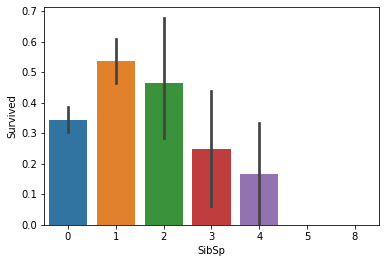

In [327]:
sns.barplot(x ='SibSp',y='Survived',data=titanic_new)

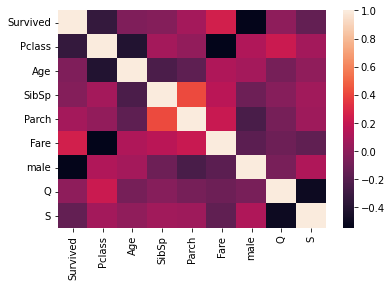

In [328]:
# Checking for independence between features¶
# 
sns.heatmap(titanic_new.corr())

In [329]:
# Fare and Pclass are not independent of each other, so I am going to drop these.
# 
titanic_new.drop(['Fare'],axis=1,inplace=True)
titanic_new.head()

,Survived,Pclass,Age,SibSp,Parch,male,Q,S
0,0,3,22.0,1,0,1,0,1
1,1,1,38.0,1,0,0,0,0
2,1,3,26.0,0,0,0,0,1
3,1,1,35.0,1,0,0,0,1
4,0,3,35.0,0,0,1,0,1


In [330]:
titanic_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Age       889 non-null    float64
 3   SibSp     889 non-null    int64  
 4   Parch     889 non-null    int64  
 5   male      889 non-null    uint8  
 6   Q         889 non-null    uint8  
 7   S         889 non-null    uint8  
dtypes: float64(1), int64(4), uint8(3)
memory usage: 76.6 KB


## 7. Implementing the Solution

In [331]:
# Splitting our dataset
#
X = titanic_new.drop("Survived",axis=1)
y = titanic_new["Survived"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)



In [332]:
#Applying Standard scaling to get optimized result
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [333]:
# Fitting our model
# 
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)

In [334]:
#Let's see how our model performed
print(classification_report(y_test, y_pred))
#logisticRegression gives an accuracy of 78%.

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       164
           1       0.72      0.70      0.71       103

    accuracy                           0.78       267
   macro avg       0.77      0.76      0.77       267
weighted avg       0.78      0.78      0.78       267



In [335]:
# Evaluating the model
#
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix
# The results from the confusion matrix tell us that 136 and 72 are the number of correct predictions. 
# 31 and 28 are the number of incorrect predictions.

array([[136,  28],
       [ 31,  72]])

In [336]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

We use K Nearest Neighbor Classifier to see how it will perform on our dataset

In [339]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [340]:
# Evaluating the Algorithm
# ---
# For evaluating an algorithm, confusion matrix, precision, recall and f1 score are the most commonly used metrics. 
# The confusion_matrix and classification_report methods of the sklearn.metrics can be used to calculate these metrics. 
# ---
# 
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[144  20]
 [ 31  72]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       164
           1       0.78      0.70      0.74       103

    accuracy                           0.81       267
   macro avg       0.80      0.79      0.79       267
weighted avg       0.81      0.81      0.81       267



We try to improve the model by performing the Linear Discrimant Analysis

In [341]:
#performing LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

In [342]:
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [343]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

[[139  25]
 [ 34  69]]
Accuracy0.7790262172284644


8. Conclusion


After a thorough and exhaustive analysis using the models above, we see that the difference between the different models accuracy scores does not have a very big margin.

Support Vector Classifier has the highest performance of 82%, thus I recommend the model to be used.

9. Follow up questions

At this point, we can refine our question or collect new data, all in an iterative process to get at the truth.

a). Did we have the right data? YES

b). Do we need other data to answer our question? NO

c). Did we have the right question? YES